# Syllable usage balancing

This notebooks expects `.env` file specifying the `KILLIFISH_DATA_DIR` environmental variable pointing to the relevant data directory.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

import numpy as onp

import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

import dtd
import dtd.data.killifish

load_dotenv();  # load environment variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load raw counts of data. No need to split by subject.
data_dir = os.getenv("KILLIFISH_DATA_DIR")
data = dtd.data.killifish.construct_subject_concatenated_kf(data_dir, mask_frac=0)

syllable_counts = onp.asarray(data['tensor'])
name_and_age_labels = data['mode_0']

# syllable_labels`` are currently stored as ['<coarse_id>-<syllable_index>', ...]
# we discard the syllable index and just keep the coarse syllable label

syllable_labels = data['mode_2']
syllable_labels = [lbl.split('-')[0] for lbl in syllable_labels]

D, T, V = syllable_counts.shape
print(f"{syllable_counts.shape=}")

syllable_counts.shape=(14411, 144, 100)


**Visualization functions**

In [3]:
def set_coarse_syllable_labels(ax, axis='x', which='minor', syllable_labels=syllable_labels):
    """Add coarse syllable labels to specified axis.
    
    We assume that syllables are already permuted to be contiguously arranged by coarse cluster,
    i.e. ['c0', 'c0', ..., 'c9', 'c9', ...] and not ['c0', 'c9', 'c2', 'c0', ...].
    """
    
    V = len(syllable_labels)

    # Get unique coarse labels and their indices. Manually sort because e.g. 'c10' returned before 'c2'
    coarse_labels, coarse_indices = onp.unique(syllable_labels, return_index=True)
    coarse_labels = coarse_labels[onp.argsort(coarse_indices)]
    coarse_indices = onp.sort(coarse_indices)

    # Calculate tick positions. Add 0.5 to center, and 0.01 so it doesn't clash with integer-based syllable ticks
    # (if major/minor ticks overlap, major tick conditions will take precedence and unexpected behavior may occur)
    ticks = 0.5 * (onp.concatenate([coarse_indices[1:], [V]]) - coarse_indices) + coarse_indices + 0.51

    if axis == 'x':
        ax.set_xticks(ticks, minor=(which=='minor'))
        ax.set_xticklabels(coarse_labels, minor=(which=='minor'))
        ax.tick_params(axis='x', which=which, bottom=False)  # don't draw the minor ticks
    elif axis == 'y':
        ax.set_yticks(ticks, minor=(which=='minor'))
        ax.set_yticklabels(coarse_labels, minor=(which=='minor'))
        ax.tick_params(axis='y', which=which, left=False)  # don't draw the minor ticks
    else:
        raise ValueError("Expected 'axis' to be in \{'x', 'y'\}, " + f"but got {axis}.")
    
    return coarse_labels, coarse_indices

In [4]:
def show_example_subjects_by_example_syllable_usages(
    counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show, syllables_to_show,
    vmin, vmax, vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax}]"),
    xtick_hrs=[0,8,16,24]
):
    """Plot a grid of example subjects by example syllable usages, over age and time.
    
    Parameters
    ----------
    counts_by_subject: list of ndarrays, length (n_subjects,)
        List of ndarrays, shape (D_subject, T, V)
    ages_by_subject: list, length (n_subjects,)
        List of age vectors, length (D_subject,); used to label y-axis
    subject_names: list, length (n_subjects,)
        Subject names, used to label rows
    subjects_to_show: list of int
    syllables_to_show: list of int

    Returns
    -------
    fig, axs
    """

    n_subjects = len(subjects_to_show)
    n_syllables = len(syllables_to_show)

    # Size rows based on number of days recorded
    height_ratios = onp.array([len(ages_by_subject[i]) for i in subjects_to_show], dtype=float)
    height_ratios /= min(height_ratios)

    fig, axs = plt.subplots(
        nrows=n_subjects, ncols=n_syllables,
        gridspec_kw={"height_ratios": height_ratios, "hspace": 0.2, "wspace": 0.1},
        figsize=(16,9)
    )

    for i_col, syllable_idx in enumerate(syllables_to_show):

        for i_row, subject_idx in enumerate(subjects_to_show):

            ax = axs[i_row, i_col]
            
            ax.imshow(
                counts_by_subject[subject_idx][:, :, syllable_idx],
                cmap='Greys', vmin=vmin, vmax=vmax
            )
            
            # Set x-ticksm but don't show labels
            ax.set_xticks(onp.array(xtick_hrs)*6)
            ax.set_xticklabels(xtick_hrs)
            ax.tick_params(labelleft=False, labelbottom=False)

            # Set y-ticks
            ages = ages_by_subject[subject_idx]
            day_freq = 15 if len(ages) < 60 else 30
            start_age = ((ages[0] // day_freq) + 1) * day_freq
            end_age = ((ages[-1] // day_freq) + 1) * day_freq
            ax.set_yticks(onp.arange(start_age, end_age, day_freq) - ages[0])
            ax.set_yticklabels(onp.arange(start_age, end_age, day_freq))

    # Label y-axis of first column with name and ages
    for ax, subject_idx in zip(axs[:,0], subjects_to_show):
        ax.tick_params(labelleft=True, labelsize='x-small')
        ax.set_ylabel("age (days)", fontsize='small')

        # Label row with subject name                        
        ax.text(-0.8, 0.5, subject_names[subject_idx], transform=ax.transAxes,
                weight='demibold', fontsize='small',
                va='center', ha='right',)

    # Label x-axis of bottom row with time-of-days
    for ax in axs[-1]:
        ax.tick_params(labelbottom=True, labelsize='x-small')
        ax.set_xlabel('time-of-day (h)', fontsize='small')

    # Set title of top row with syllable label
    for ax, syllable_idx in zip(axs[0], syllables_to_show):
        vlabel = vlabel_fmt(vmin, vmax)
        ax.set_title(f"syllable {syllable_idx}\n{vlabel}", fontsize='medium', y=1.1)

    sns.despine(offset=5)

    return fig, axs

## Syllable usage is imbalanced and may obscure important changes in less globally used syllables

In [5]:
# Split data by subjects so we don't try to correlate across subjects
all_names, all_ages = list(zip(*name_and_age_labels))
subject_names, subject_indices = onp.unique(all_names, return_index=True)

# Split data by subjects
ages_by_subject = onp.split(all_ages, subject_indices[1:])
subject_lifespans = [ages[-1] for ages in ages_by_subject]
counts_by_subject = onp.split(syllable_counts, subject_indices[1:], axis=0)
print(f"{counts_by_subject[0].shape=}")

# Sort subjects by lifespan
argsort_by_lifespan = onp.argsort(subject_lifespans)
ages_by_subject = [ages_by_subject[i] for i in argsort_by_lifespan]
counts_by_subject = [counts_by_subject[i] for i in argsort_by_lifespan]
subject_names = [subject_names[i] for i in argsort_by_lifespan]

counts_by_subject[0].shape=(198, 144, 100)


Text(0.5, 0.98, 'raw syllable usage count heatmap')

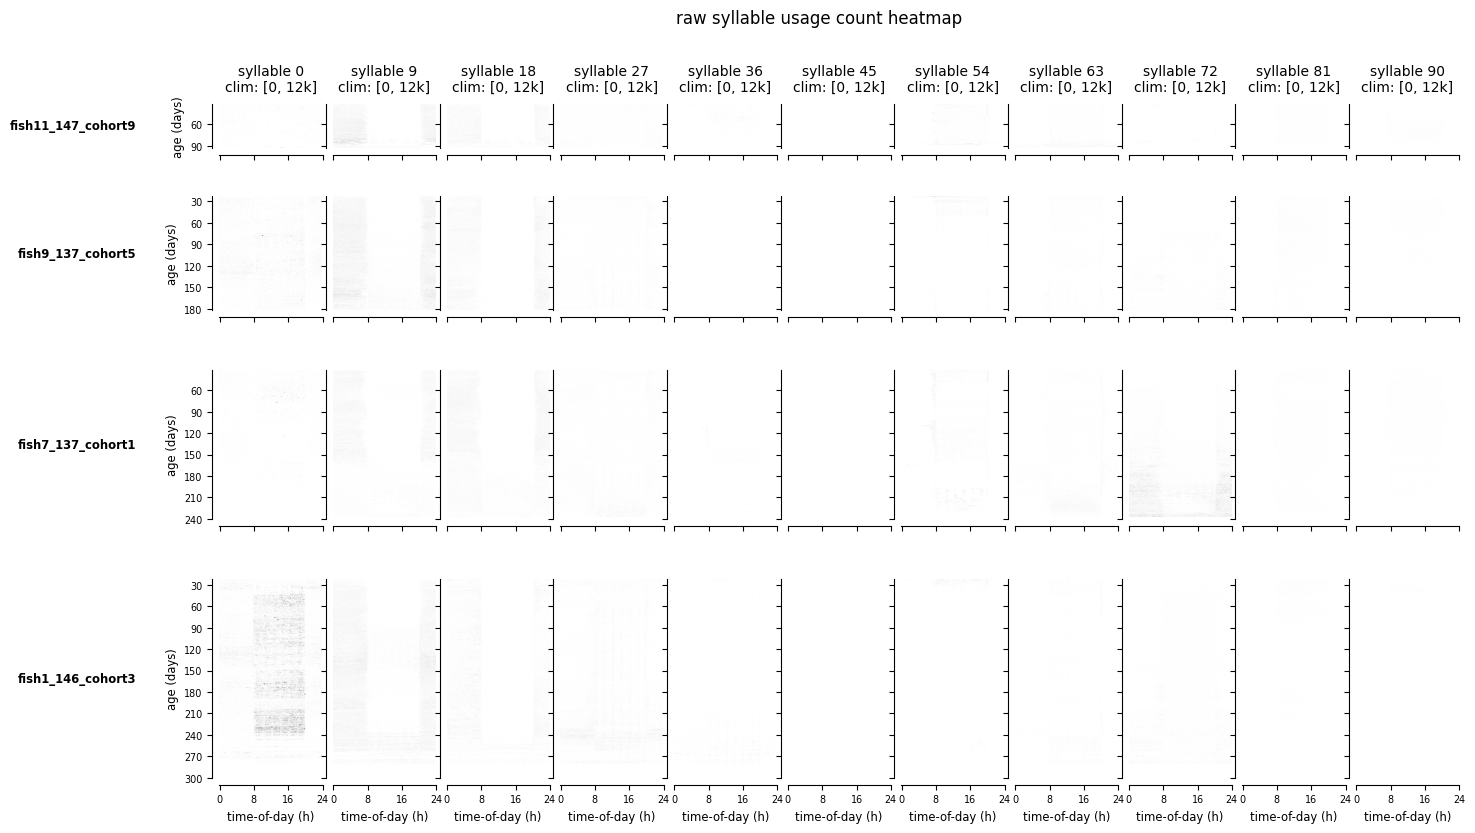

In [6]:
subjects_to_show = onp.linspace(5, len(subject_names)-10, num=4, dtype=int)  # don't show the extremes
syllables_to_show = onp.linspace(0, 100-1, endpoint=False, num=11, dtype=int)
total_counts_per_bin = syllable_counts[0,0].sum()  # this is constant across all bins

fig, axs = show_example_subjects_by_example_syllable_usages(
    counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show=subjects_to_show, syllables_to_show=syllables_to_show,
    vmin=0, vmax=total_counts_per_bin,
    vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax//1e3:.0f}k]"),
    xtick_hrs=[0,8,16,24]
)

fig.suptitle("raw syllable usage count heatmap")

**Figure | Raw syllable usage over time and age, for selected syllables and fish.**

In some of the panels, we can see differences in usage between day and night (_x-axis_) and over age (_y-axis_).
However, when just using raw syllable count, which is proportional to using per-timebin frequency, it appears that the signal can be very weak.

To take a look at what might be going on, let's visualize the empirical distribution of the syllable usages.

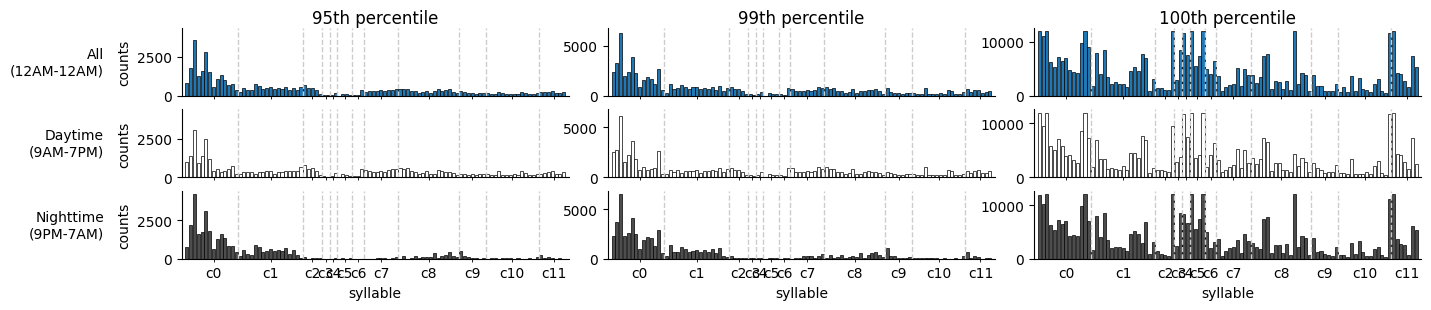

In [7]:
# Now, let's split by time of day

percentiles = [95, 99, 100]
bins_per_hr = 6
time_groups = {
    "All\n(12AM-12AM)": {
        "syllable_counts": syllable_counts,
        "bar_kws": {'fc': 'C0', 'ec': 'k', 'lw': 0.5},
    },
    "Daytime\n(9AM-7PM)": {
        "syllable_counts": syllable_counts[:,9*bins_per_hr:19*bins_per_hr],
        "bar_kws": {'fc': 'w', 'ec': 'k', 'lw': 0.5},
    },
    "Nighttime\n(9PM-7AM)": {
        "syllable_counts": onp.concatenate([syllable_counts[:,:7*bins_per_hr], syllable_counts[:,21*bins_per_hr:]], axis=1),
        "bar_kws": {'fc': "0.3", 'ec': 'k', 'lw': 0.5},
    }
}

fig, axs = plt.subplots(
    nrows=len(time_groups), ncols=len(percentiles),
    sharex=True, sharey='col',
    gridspec_kw={"wspace": 0.1},
    figsize=(16, 1*len(time_groups))
)

for i_row, grp in enumerate(time_groups.values()):
    for i_col, pct in enumerate(percentiles):

        pct_syllable_counts = onp.percentile(grp['syllable_counts'], pct, axis=(0,1))

        ax = axs[i_row, i_col]
        
        ax.bar(range(V), pct_syllable_counts, **grp['bar_kws'])
        
        # ax.set_xticks(range(V)); ax.set_xticklabels([])
        ax.tick_params(axis='x', which='major', labelbottom=False, bottom=False)

        # formatting
        ax.spines[['top', 'right']].set_visible(False)
        ax.margins(x=0.01)

# Add x-titles to rows, label x axis:
for ax, grp_name in zip(axs[:,0], time_groups.keys()):
    ax.text(-0.2, 0.5, grp_name, transform=ax.transAxes, va='center', ha='right')
    ax.set_ylabel("counts")

# Add y-titles to columns
for ax, pct in zip(axs[0], percentiles):
    ax.set_title(f"{pct}th percentile", y=0.95)

# Add y-labels to bottom row
for ax in axs[-1]:
    ax.set_xlabel("syllable")

# Add coarse labels
_, coarse_indices = set_coarse_syllable_labels(ax, axis='x', which='minor')
for ax in axs.ravel():
    for idx in coarse_indices[1:]:
        ax.axvline(idx+0.5, color='0.8', ls='--', lw=1)


**Figure | Syllable vs. usage count, by timeblock and percentile.**

The 95th, 99th, and 100th percentile usages of each syllable (_columns_), across all days and subjects, for the indicated timeblock (_rows_).
Note that the visualized syllable usages may not exist in the dataset, and does not sum to a constant count, since the _p_-th percentile is found for each syllable, and each timeblock, independently.

1. **There are timebins with outlier usage in syllables, but these may be indicative of anomalous events.**
    - The 95th and 99th percentile syllable usage histograms (_left_ and _center_) have similar profiles but differ significantly from the 100th percentile syllable usage histogram (_right_).
    - This indicates that there are timebins with outlier syllable usage distributions. However, it is unclear whether we should remove these outlier timebins because they may be indicative of anomalous events.

2. **Syllables are are not used in a balanced/uniform manner.**
    - In each of the subplots (i.e. regardless of percentile and regardless of time block), we see a fairly imbalanced distribution in syllable usage. In particular, we can high usage of 'c0' syllables, i.e. slow and pause syllables.
    - We can see slight differences in syllable usage between day and night time blocks, as expected, but they are muted by the "class imbalance". For example, in the 95th and 99th percentiles, we can see that
      - syllables in the 'c0' and 'c1' groups, corresponding to slower behavioral motifs, are used more frequently at nighttime, and
      - syllables in the 'c2', and 'c8' through 'c11' groups, corresponding to more active motifs, are used more frequently during the daytime.
    - Syllables that are "globally" less used may still be indicative of key changes in the aging process. We would like to balance the data so that changes in these less used syllables may still be captured.

<BarContainer object of 100 artists>

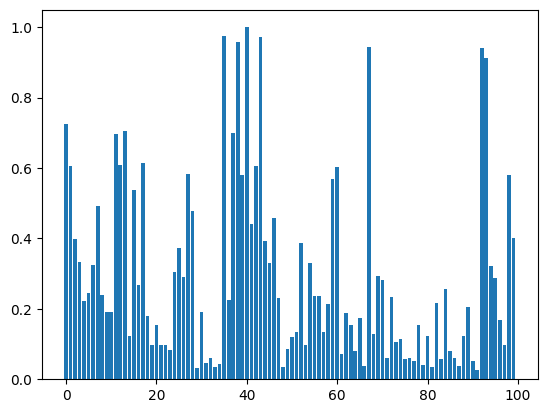

In [8]:
# calculate difference in syllable count usage between maximum usage and p-th percentile usage, normalized by counts_per_timebin
# find syllables where maximum difference in usage is > 50%? We will follow-up on this sometime in the future.

pct = 99.5  # chosen such that difference is taken over 144 timebins * 82 subjects number of samples, ~10k :shrug:

counts_per_timebin = syllable_counts[0,0].sum()

diff = (onp.max(syllable_counts, axis=(0,1)) - onp.percentile(syllable_counts, pct, axis=(0,1))) / counts_per_timebin
plt.bar(onp.arange(V), diff)

## Balancing via min-max scaling

One way that we can scale data is to standardize by min-max scaling. To respect the fact that syllables may have different "typical" usages depending on time, we perform min-max scaling for syllable $v$ and time $t$ across all days.
This is in constrast to min-max scaling syllable $v$ across time bins and days.

This may help to better highlight differences in syllable usage, perhaps of the last used syllables.

### Min-max scaling

In [7]:
# note that we set min to 0, hence it doesn't appear in equation
scaled_syllable_counts = syllable_counts / (syllable_counts.max(axis=0, keepdims=True))  # dbz may occur if syllable is never used; set to 0
scaled_syllable_counts[~onp.isfinite(scaled_syllable_counts)] = 0.  

scaled_counts_by_subject = onp.split(scaled_syllable_counts, subject_indices[1:], axis=0)
print(f"{scaled_counts_by_subject[0].shape=}")

# Sort subjects by lifespan
scaled_counts_by_subject = [scaled_counts_by_subject[i] for i in argsort_by_lifespan]

scaled_counts_by_subject[0].shape=(198, 144, 100)


Text(0.5, 0.98, 'min-max scaled syllable usage count heatmap')

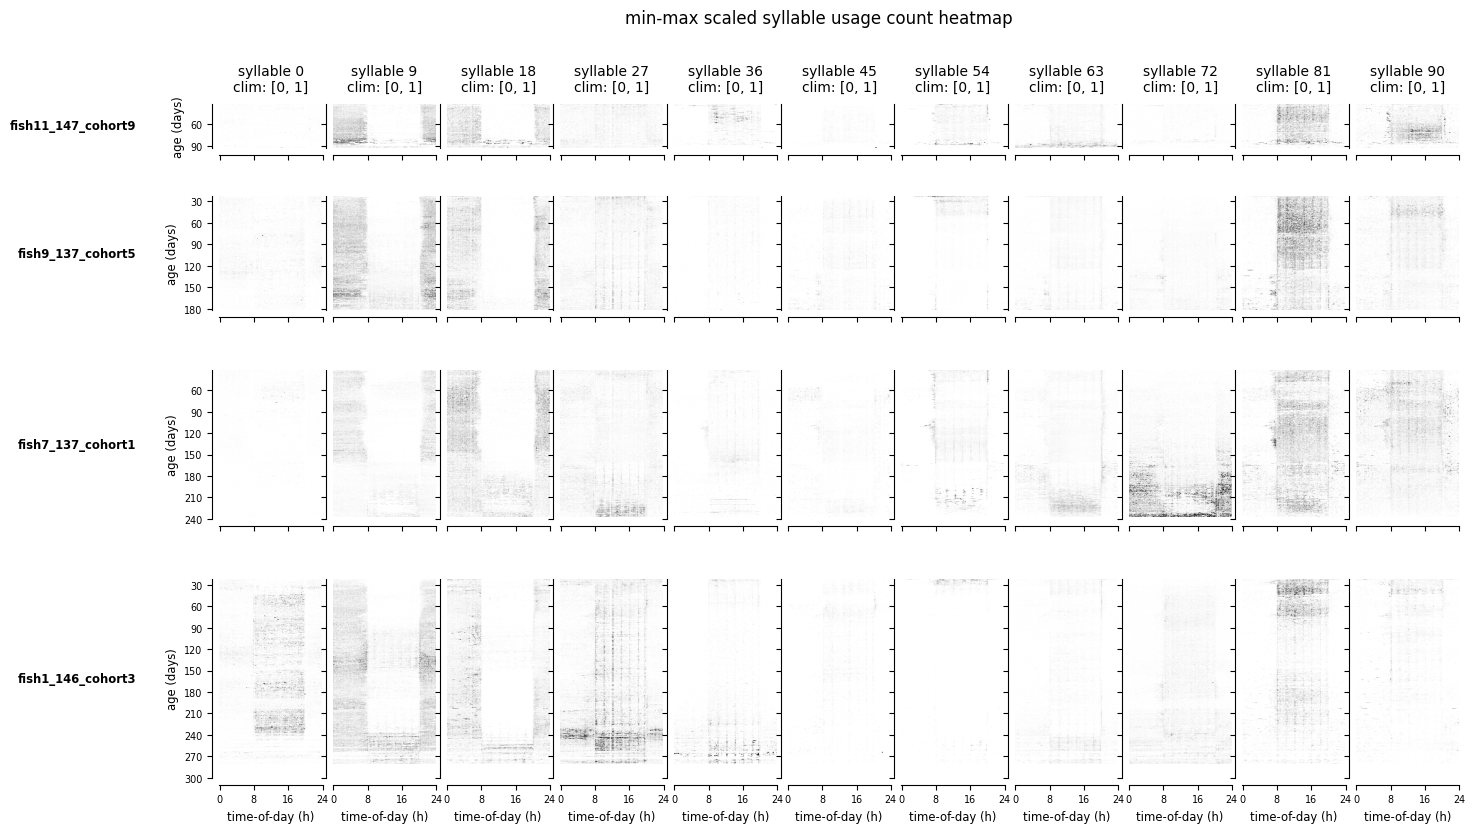

In [8]:
subjects_to_show = onp.linspace(5, len(subject_names)-10, num=4, dtype=int)  # don't show the extremes
syllables_to_show = onp.linspace(0, 100-1, endpoint=False, num=11, dtype=int)
total_counts_per_bin = syllable_counts[0,0].sum()  # this is constant across all bins

fig, axs = show_example_subjects_by_example_syllable_usages(
    scaled_counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show=subjects_to_show, syllables_to_show=syllables_to_show,
    vmin=0, vmax=1,
    vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax}]"),
    xtick_hrs=[0,8,16,24]
)

fig.suptitle("min-max scaled syllable usage count heatmap")

**Figure | Min-max scaled syllable usage over time and age, for selected syllables and fish.**

Compared to the raw syllable usage plot, we see considerably greater "signal" with this scaling.

However, some syllables (e.g. syllable 45) still has very low signal, suggesting that there is another subject at some timebin that has an outlier usage.

### Robust min-max scaling

We indicated above that we want to preserve outliers, but that may be not always be desirable. Here, we scale by the 99.9-th percentile

In [9]:
# note that we set min to 0, hence it doesn't appear in equation
pct = 99.5
pct_scaled_syllable_counts = syllable_counts / onp.percentile(syllable_counts, pct, axis=0)  # any nans are due to dbz
pct_scaled_syllable_counts[~onp.isfinite(pct_scaled_syllable_counts)] = 0.

pct_scaled_counts_by_subject = onp.split(pct_scaled_syllable_counts, subject_indices[1:], axis=0)
print(f"{pct_scaled_counts_by_subject[0].shape=}")

# Sort subjects by lifespan
pct_scaled_counts_by_subject = [pct_scaled_counts_by_subject[i] for i in argsort_by_lifespan]

/tmp/ipykernel_5863/2063599550.py:3: RuntimeWarning: divide by zero encountered in divide
  pct_scaled_syllable_counts = syllable_counts / onp.percentile(syllable_counts, pct, axis=0)  # any nans are due to dbz
/tmp/ipykernel_5863/2063599550.py:3: RuntimeWarning: invalid value encountered in divide
  pct_scaled_syllable_counts = syllable_counts / onp.percentile(syllable_counts, pct, axis=0)  # any nans are due to dbz


pct_scaled_counts_by_subject[0].shape=(198, 144, 100)


Text(0.5, 0.98, '99.5-th percentile scaled syllable usage count heatmap')

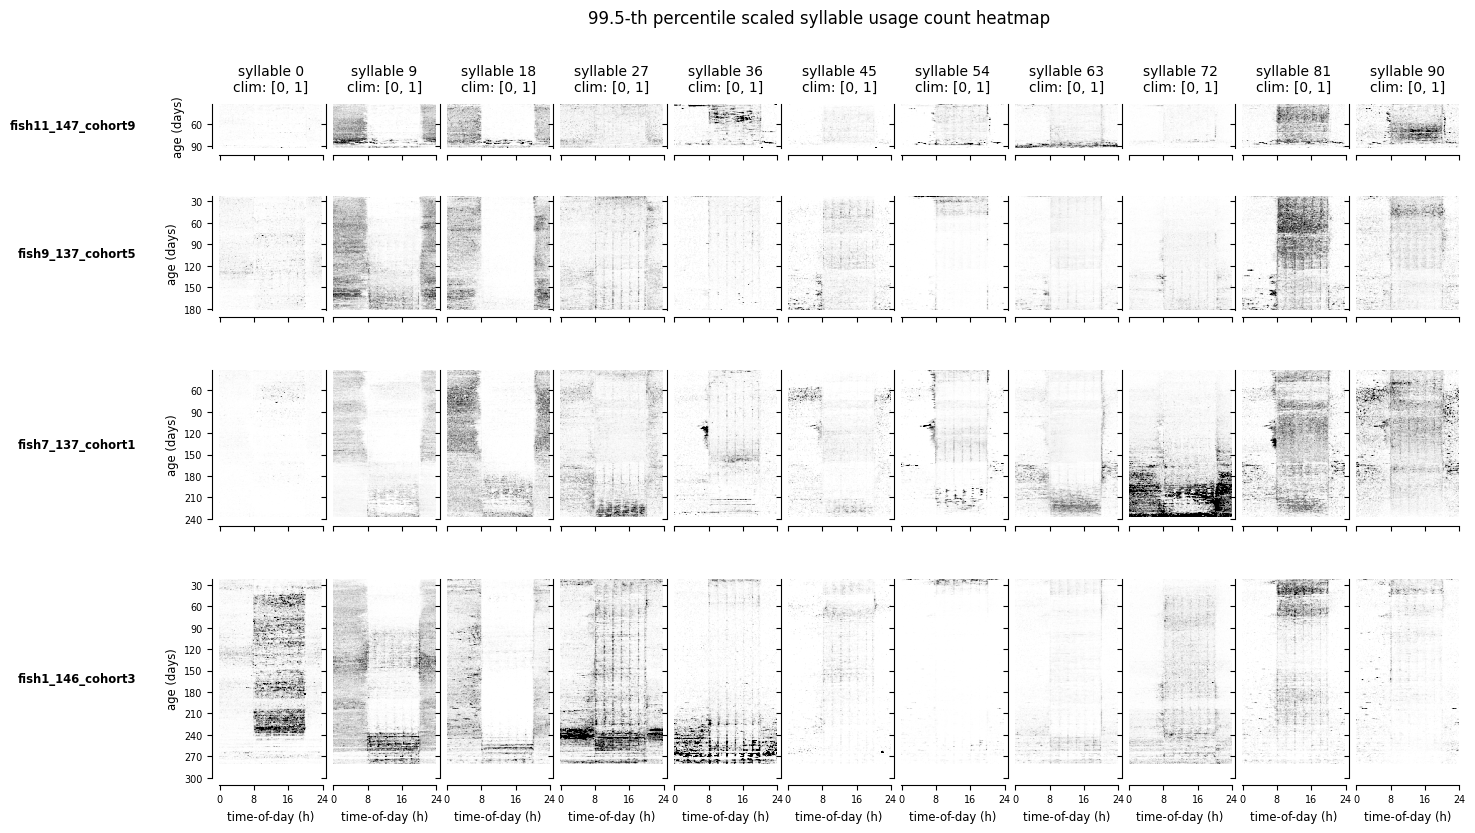

In [10]:
fig, axs = show_example_subjects_by_example_syllable_usages(
    pct_scaled_counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show=subjects_to_show, syllables_to_show=syllables_to_show,
    vmin=0, vmax=1,
    vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax}]"),
    xtick_hrs=[0,8,16,24]
)

fig.suptitle(f"{pct}-th percentile scaled syllable usage count heatmap")

**Figure | Min-max scaled syllable usage over time and age, for selected syllables and fish.**

Compared to the min-max scaled syllable usage plot, we can better see some pattern in syllable 0 for the first 3 subjects, and syllable 54 for the last subject.

### Subject-specific robust min-max scaling

In [11]:
pct = 99.5

individual_pct_scaled_syllable_counts_by_subject = []

for counts in counts_by_subject:
    scaled_counts = onp.array(counts / onp.percentile(counts, pct, axis=0))
    scaled_counts[onp.isnan(scaled_counts)] = 0.
    individual_pct_scaled_syllable_counts_by_subject.append(scaled_counts)

/tmp/ipykernel_5863/4209602633.py:6: RuntimeWarning: invalid value encountered in divide
  scaled_counts = onp.array(counts / onp.percentile(counts, pct, axis=0))
/tmp/ipykernel_5863/4209602633.py:6: RuntimeWarning: divide by zero encountered in divide
  scaled_counts = onp.array(counts / onp.percentile(counts, pct, axis=0))


Text(0.5, 0.98, 'subject-specific 99.5th percentile scaled syllable usage count heatmap')

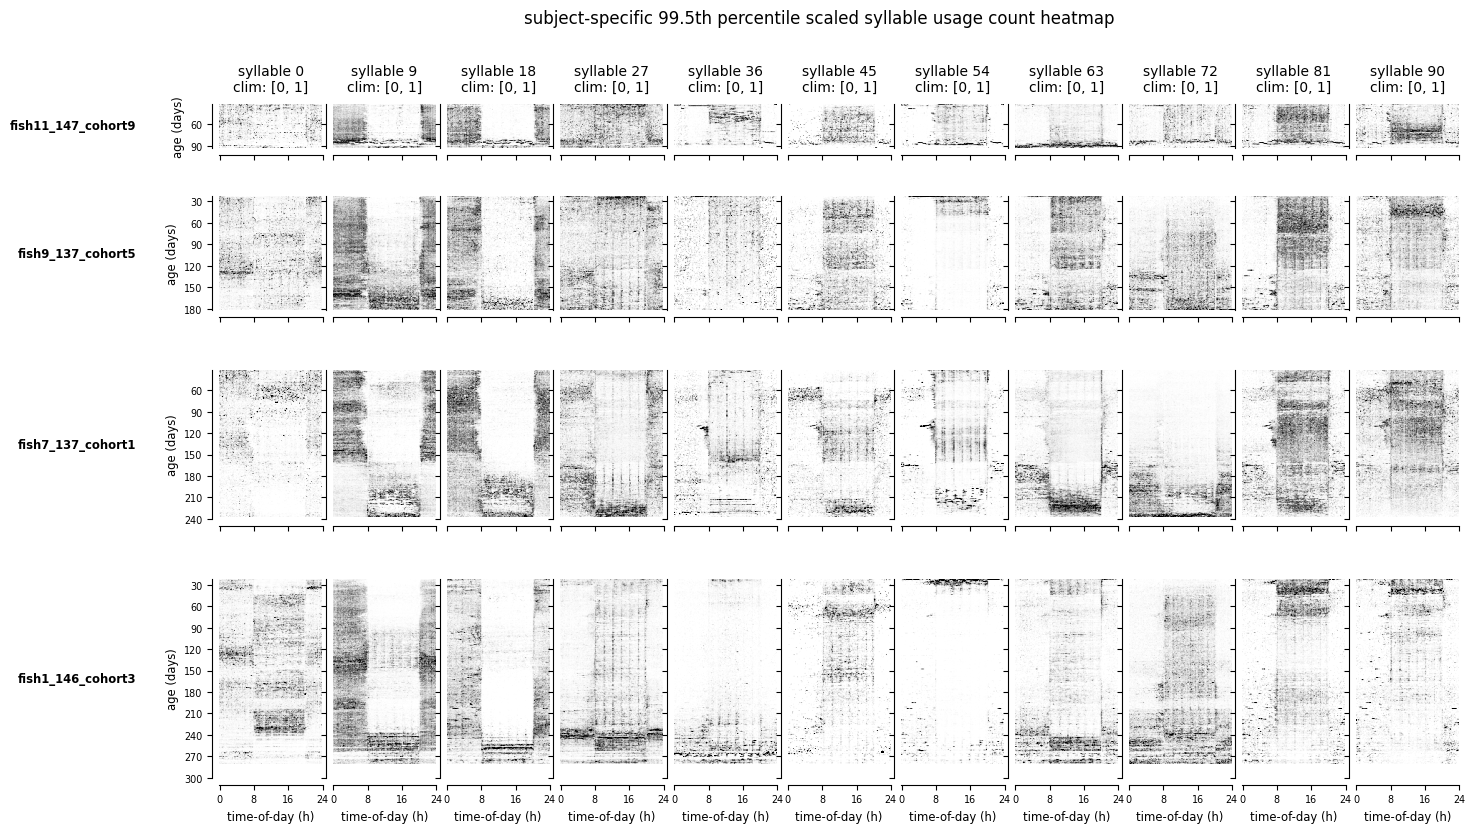

In [12]:
fig, axs = show_example_subjects_by_example_syllable_usages(
    individual_pct_scaled_syllable_counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show=subjects_to_show, syllables_to_show=syllables_to_show,
    vmin=0, vmax=1,
    vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax}]"),
    xtick_hrs=[0,8,16,24]
)

fig.suptitle(f"subject-specific {pct}th percentile scaled syllable usage count heatmap")

**Figure | Subject-specific robust min-max scaled syllable usage over time and age, for selected syllables and fish.**

Here, we apply the robust min-max scaling, but on a per-subject basis. Qualitatively, this appears to be the best scaling so far because, for every single pannel (subject and syllable pair), we can see identify time- and age-dependent changes.

The drawback of this method is that it it not immediately clear how to do this scaling in an online fashion. Here, we have the benefit of retrospectively analyzing each individual's behavior.

## Adjusting scaled syllable usages

As we explored in the previous section, applying some sort of syllable- and timebin-specific (and perhaps subject-specific) scaling, would improve the syllable usage balance and better enhance the relative change in usages that may be informative of aging.

However, scaled syllable usage vectors no longer sum to 1, and they no longer represent a pseudo-distribution of usages.

What would it mean if, after scaling, we rescale everything so they sum to 1?

Let the scaled syllable usage be:
$$
x^\textrm{scaled}_{dtv} = \frac{x_{dtv}}{\textrm{max}_d\{x_{dtv}\}}
$$
Then, can we simply use
$$
\hat{x}_{dtv} = \frac{x^\textrm{scaled}_{dtv}}{\sum_{v} x^\textrm{scaled}_{dtv}}
$$

Text(0.5, 1.0, 'histogram of sums')

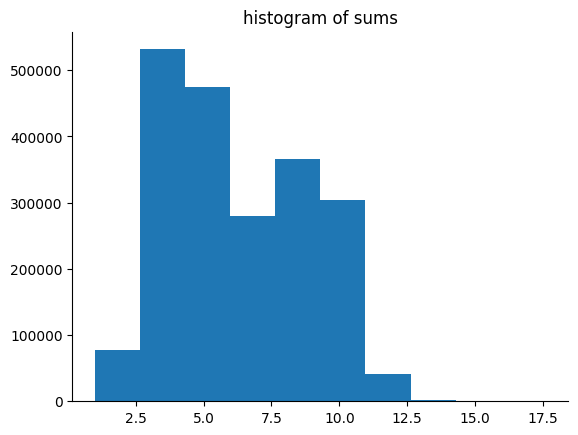

In [13]:
plt.hist(scaled_syllable_counts.sum(axis=-1).ravel())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("histogram of sums")

**Figure | Min-max scaled vectors typically sum to some value between 3 and 10**

scaled_syllable_freq.shape=(14411, 144, 100)


Text(0.5, 0.98, 'Normalized min-max scaled syllable counts')

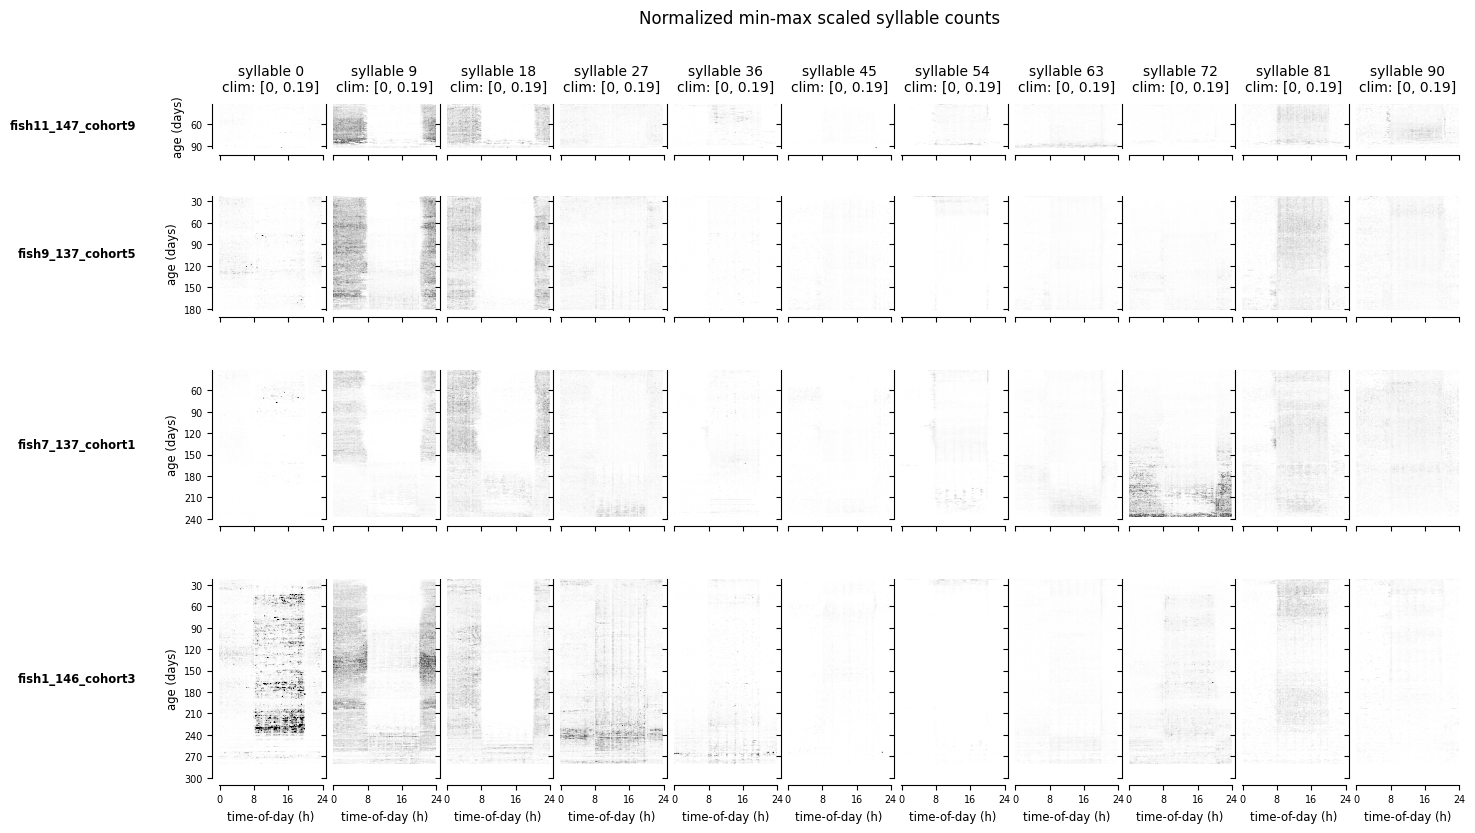

In [28]:
scaled_syllable_freq = scaled_syllable_counts / scaled_syllable_counts.sum(axis=-1, keepdims=True)
print(f"{scaled_syllable_freq.shape=}")

# Split then sort subjects by lifespan
normd_scaled_counts_by_subject = onp.split(scaled_syllable_freq, subject_indices[1:], axis=0)
normd_scaled_counts_by_subject = [normd_scaled_counts_by_subject[i] for i in argsort_by_lifespan]

# ----

vmax = 2*onp.percentile(scaled_syllable_freq, 99.5)

fig, axs = show_example_subjects_by_example_syllable_usages(
    normd_scaled_counts_by_subject, ages_by_subject, subject_names,
    subjects_to_show=subjects_to_show, syllables_to_show=syllables_to_show,
    vmin=0, vmax=vmax,
    vlabel_fmt=(lambda vmin, vmax: f"clim: [{vmin}, {vmax:.2f}]"),
    xtick_hrs=[0,8,16,24]
)

fig.suptitle(f"Normalized min-max scaled syllable counts")

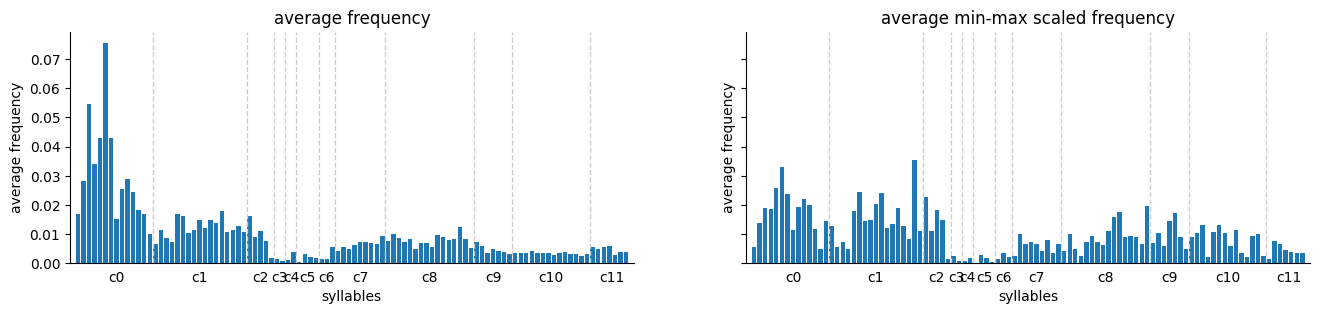

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,3))

for ax, freq, name in zip(axs, [syllable_freq, scaled_syllable_freq], ["average frequency", "average min-max scaled frequency"]):
    ax.bar(range(V), freq.mean(axis=(0,1)))

    ax.set_title(name)

    ax.set_xlabel('syllables')
    ax.margins(x=0.01)
    ax.tick_params(axis='x', which='major', labelbottom=False, bottom=False)
    _, coarse_indices = set_coarse_syllable_labels(ax, axis='x', which='minor')
    for idx in coarse_indices[1:]:
        ax.axvline(idx+0.5, color='0.8', ls='--', lw=1)
    

    ax.set_ylabel('average frequency')

    ax.spines[['top', 'right']].set_visible(False)

**Figure | Average syllable frequency between raw and min-max scaled counts.**

The average usage frequency of the min-max scaled counts (_right_) is more balanced (less skewed) than the average usage frequency of the raw counts (_left_).